# Compressive sensing example


In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os
import sigpy.mri as mr

import sigpy as sp
import sigpy.mri as mr
from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
#from models import *
#from utils.denoising_utils import *

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


## Load example image

In [2]:
def crop_center(img,cropx,cropy):
    #y,x = img.shape
    y = img.shape[-2]
    x = img.shape[-1]
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    if len(img.shape) == 2:
        return img[starty:starty+cropy,startx:startx+cropx]
    if len(img.shape) == 3:
        return img[0,starty:starty+cropy,startx:startx+cropx]

path = './test_data/'
img_name = "poster"
#img_name = "F16_GT"
#img_name = "sf4_rgb"
#img_name  = 'library'
img_path = path + img_name + ".png"

img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)

img_np_small = np.array([crop_center(img_np[0],128,128)])
img_var = np_to_var(img_np_small).type(dtype)
output_depth = img_np.shape[0]

## Define forward model

In [3]:
X = img_var.view(-1, np.prod(img_var.shape) )
n = X.shape[1]
m = int(n/3)
A = torch.empty(n,m).uniform_(-1, 1).type(dtype)
A *= 1/np.sqrt(m)

def forwardm(img_var):
    X = img_var.view(-1 , np.prod(img_var.shape) ) 
    return torch.mm(X,A)

measurement = forwardm(img_var)

## DD reconstruction and helper functions

In [4]:
def get_net_input(num_channels,w=128,h=128):
    totalupsample = 2**len(num_channels)
    width = int(128/totalupsample)
    height = int(128/totalupsample)
    shape = [1,num_channels[0], width, height]
    net_input = Variable(torch.zeros(shape)).type(dtype)
    net_input.data.uniform_()
    net_input.data *= 1./10
    return net_input

def get_random_img(num_channels,ni=None):
    if ni is None:
        ni = get_net_input(num_channels)
    net = decodernw(1,num_channels_up=num_channels,need_sigmoid=True).type(dtype)
    print("generated random image with", num_channels, " network has ", num_param(net) )
    return net(ni)

def myimgshow(plt,img):
    if(img.shape[0] == 1):
        plt.imshow(np.clip(img[0],0,1),cmap='gray')
    else:
        plt.imshow(np.clip(img.transpose(1, 2, 0),0,1))
    plt.axis('off')    
    
def plot_img(img_ref): 
    fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure   
    ax1 = fig.add_subplot(231)
    ax1.imshow(img_ref,cmap='gray')
    #ax1.set_title('Original image')
    ax1.axis('off')
    
def init_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            #m.weight.data.uniform_()
            #torch.nn.init.xavier_uniform(m.weight)
            #nn.init.uniform_(m.weight)
            torch.nn.init.normal_(m.weight)

def snr(x_hat,x_true):
    x_hat = x_hat.flatten()
    x_true = x_true.flatten()
    mse= np.sum( np.square(x_hat-x_true) )
    #snr_ = 10.*np.log(maxv**2/mse)/np.log(10.)
    snr_ = mse / np.sum( np.square(x_true) )
    return snr_

In [5]:
def dd_recovery(measurement,img_var,num_channnels,num_iter=6000,apply_f=forwardm,ni=None):
    net = decodernw(1,num_channels_up=num_channels,need_sigmoid=True).type(dtype)
    #net.apply(init_weights)
    mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                                net_input=ni,
                        reg_noise_std=0.0,num_iter=num_iter,LR = 0.005,
                        img_noisy_var=measurement.type(dtype),
                        net=net,apply_f = apply_f,img_clean_var=img_var.type(dtype),
                        upsample_mode='bilinear',
                        )
    print(num_param(net))
    out_img_var = net( ni.type(dtype) )
    return out_img_var

## Example reconstruction

This demonstrates that reconstruction with a deep decoder works well, but a deconvolutional decoder does not enable good reconstructions.

In [6]:
k=22
num_channels = [k]*4
measurement = forwardm(img_var).type(dtype)
out_img_var = dd_recovery(measurement,img_var,num_channels)

input shape:  [1, 22, 8, 8]
optimize with adam 0.005
2662ation 05990    Train loss 0.000260  Actual loss 0.000536 Actual loss orig 0.000536 


In [7]:
def dconv_recovery(img_var):
    measurement = forwardm(img_var).type(dtype)
    num_channels = [6]*6
    net = deconv_decoder(1,num_channels_up=num_channels,filter_size=4,stride=2,padding=1).type(dtype)
    mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=0.0,num_iter=5000,LR = 0.0025,
                        img_noisy_var=measurement,
                        net=net,apply_f = forwardm,img_clean_var=img_var.type(dtype),
                        upsample_mode='deconv' )
    print(num_param(net))
    out_img_var = net( ni.type(dtype) )
    return out_img_var

out_img_dc_var = dconv_recovery(img_var)

input shape:  [1, 6, 4, 4]
optimize with adam 0.0025
2946ation 04990    Train loss 0.000692  Actual loss 0.003695 Actual loss orig 0.003695 


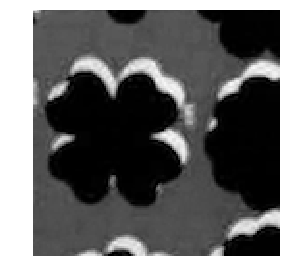

In [8]:
plot_img(img_var.data.cpu().numpy()[0,0])
#plot_img(out_img_var.data.cpu().numpy()[0,0])
#plot_img(out_img_dc_var.data.cpu().numpy()[0,0])

def savefig(filename,img):
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.savefig(filename,bbox_inches='tight')
    
savefig(img_name + '_orig.png',img_var.data.cpu().numpy()[0,0])

# Compressive sensing on random images

Our main result shows that taking random linear measurements on the order of the number of parameters of the deep decoder is suffient for recovery is possible. In order to see whether that is also necessary and thus the number of parameters captures the complexity of the range space of the deep decoder, we conduct the following experiment to recover an image in the range of the deep decoder.

In order to generate an image, we can in principle simply choose the coefficients of the deep decoder at random. However, for a deep decoder with a fixed number of parameters, this tends to generate simple images, in that often a deep decoder with much fewer coefficients can represent it well. To ensure that we generate a sufficiently complex image, we generate an image in the range of the generator by finding the best representation of noise with the deep decoder. 

In [9]:
numpoints = 8
ms = [ int(100*np.exp(5.5/numpoints*i)) for i in range(numpoints) ] #[100,200,,17000]
print(ms)
ks = [10,20,30,50,150,250]
err = np.zeros((len(ms), len(ks)))

numit = 10

for q in range(numit):
    for j,m in enumerate(ms):
        for ell,k in enumerate(ks):
            # generate input
            num_channels = [k]*4
            ni = get_net_input(num_channels)
        
            # get random noise, and find approximation to it in the range of the generator
            img_var.data.uniform_()
            img_approx = Variable(dd_recovery(img_var,img_var,num_channels,ni=ni,apply_f=None,num_iter=3000))

            print("number useful variables / number observations", (k**2*4 + k) /m)
            print("number observations / number of variables", m/n)
            print("m,n,nump",m,n,k**2*4 + k)
            
            # generate random matrix
            A = 10*torch.empty(n,m).normal_(0, 1/np.sqrt(m)).type(dtype)
            
            def forwardm(img):
                X = img.view(-1 , np.prod(img.shape) )
                return torch.mm(X,A)

            measurement = forwardm(img_approx).type(dtype)
            out_img_var = dd_recovery(measurement,img_approx,num_channels,ni=ni,apply_f=forwardm,num_iter=10000)
    
            #plot_img(img_approx.data.cpu().numpy()[0,0])
            #plot_img(out_img_var.data.cpu().numpy()[0,0])
    
            error = snr(out_img_var.data.cpu().numpy()[0] , img_approx.data.cpu().numpy()[0])
            print("error: ", error, "\n")
            err[j,ell] += error/numit

[100, 198, 395, 786, 1564, 3110, 6186, 12303]
input provided
optimize with adam 0.005
610ration 02990    Train loss 0.079273  Actual loss 0.079273 Actual loss orig 0.079273 
number useful variables / number observations 4.1
number observations / number of variables 0.006103515625
m,n,nump 100 16384 410
input provided
optimize with adam 0.005
610ration 09990    Train loss 0.000000  Actual loss 0.006793 Actual loss orig 0.006793   
error:  0.026771985 

input provided
optimize with adam 0.005
2220ation 02990    Train loss 0.070932  Actual loss 0.070932 Actual loss orig 0.070932 
number useful variables / number observations 16.2
number observations / number of variables 0.006103515625
m,n,nump 100 16384 1620
input provided
optimize with adam 0.005
2220ation 09990    Train loss 0.059334  Actual loss 0.020901 Actual loss orig 0.020901   
error:  0.08020087 

input provided
optimize with adam 0.005
4830ation 02990    Train loss 0.063504  Actual loss 0.063504 Actual loss orig 0.063504 
numbe

13050tion 02990    Train loss 0.052826  Actual loss 0.052826 Actual loss orig 0.052826 
number useful variables / number observations 12.786259541984732
number observations / number of variables 0.0479736328125
m,n,nump 786 16384 10050
input provided
optimize with adam 0.005
13050tion 09990    Train loss 0.032019  Actual loss 0.047439 Actual loss orig 0.047439  
error:  0.16773193 

input provided
optimize with adam 0.005
114150ion 02990    Train loss 0.021552  Actual loss 0.021552 Actual loss orig 0.021552 
number useful variables / number observations 114.69465648854961
number observations / number of variables 0.0479736328125
m,n,nump 786 16384 90150
input provided
optimize with adam 0.005
114150ion 09990    Train loss 0.000891  Actual loss 0.101185 Actual loss orig 0.101185   
error:  0.33392045 

input provided
optimize with adam 0.005
315250ion 02990    Train loss 0.021399  Actual loss 0.021399 Actual loss orig 0.021399 
number useful variables / number observations 318.384223918

input provided
optimize with adam 0.005
114150ion 09990    Train loss 0.046229  Actual loss 0.044984 Actual loss orig 0.044984  
error:  0.14662193 

input provided
optimize with adam 0.005
315250ion 02990    Train loss 0.017228  Actual loss 0.017228 Actual loss orig 0.017228 
number useful variables / number observations 40.45425153572583
number observations / number of variables 0.3775634765625
m,n,nump 6186 16384 250250
input provided
optimize with adam 0.005
315250ion 09990    Train loss 0.006563  Actual loss 0.055406 Actual loss orig 0.055406  
error:  0.17636816 

input provided
optimize with adam 0.005
610ration 02990    Train loss 0.079659  Actual loss 0.079659 Actual loss orig 0.079659 
number useful variables / number observations 0.03332520523449565
number observations / number of variables 0.75091552734375
m,n,nump 12303 16384 410
input provided
optimize with adam 0.005
610ration 09990    Train loss 0.286068  Actual loss 0.002507 Actual loss orig 0.002507 
error:  0.0100842

4830ation 02990    Train loss 0.064555  Actual loss 0.064555 Actual loss orig 0.064555 
number useful variables / number observations 9.189873417721518
number observations / number of variables 0.02410888671875
m,n,nump 395 16384 3630
input provided
optimize with adam 0.005
4830ation 09990    Train loss 0.046866  Actual loss 0.030664 Actual loss orig 0.030664   
error:  0.11319579 

input provided
optimize with adam 0.005
13050tion 02990    Train loss 0.052730  Actual loss 0.052730 Actual loss orig 0.052730 
number useful variables / number observations 25.443037974683545
number observations / number of variables 0.02410888671875
m,n,nump 395 16384 10050
input provided
optimize with adam 0.005
13050tion 09990    Train loss 0.233089  Actual loss 0.042845 Actual loss orig 0.042845   
error:  0.15334797 

input provided
optimize with adam 0.005
114150ion 02990    Train loss 0.025494  Actual loss 0.025494 Actual loss orig 0.025494 
number useful variables / number observations 228.22784810

input provided
optimize with adam 0.005
13050tion 09990    Train loss 0.418217  Actual loss 0.031306 Actual loss orig 0.031306  
error:  0.110791676 

input provided
optimize with adam 0.005
114150ion 02990    Train loss 0.023515  Actual loss 0.023515 Actual loss orig 0.023515 
number useful variables / number observations 28.987138263665596
number observations / number of variables 0.1898193359375
m,n,nump 3110 16384 90150
input provided
optimize with adam 0.005
114150ion 09990    Train loss 0.023326  Actual loss 0.072480 Actual loss orig 0.072480  
error:  0.239504 

input provided
optimize with adam 0.005
315250ion 02990    Train loss 0.016915  Actual loss 0.016915 Actual loss orig 0.016915 
number useful variables / number observations 80.46623794212219
number observations / number of variables 0.1898193359375
m,n,nump 3110 16384 250250
input provided
optimize with adam 0.005
315250ion 09990    Train loss 0.085919  Actual loss 0.089928 Actual loss orig 0.089928  
error:  0.28343037

315250ion 02990    Train loss 0.016535  Actual loss 0.016535 Actual loss orig 0.016535 
number useful variables / number observations 2502.5
number observations / number of variables 0.006103515625
m,n,nump 100 16384 250250
input provided
optimize with adam 0.005
315250ion 09990    Train loss 0.000049  Actual loss 0.123133 Actual loss orig 0.123133    
error:  0.39183387 

input provided
optimize with adam 0.005
610ration 02990    Train loss 0.077497  Actual loss 0.077497 Actual loss orig 0.077497 
number useful variables / number observations 2.0707070707070705
number observations / number of variables 0.0120849609375
m,n,nump 198 16384 410
input provided
optimize with adam 0.005
610ration 09990    Train loss 0.127357  Actual loss 0.009161 Actual loss orig 0.009161   
error:  0.03629667 

input provided
optimize with adam 0.005
2220ation 02990    Train loss 0.070388  Actual loss 0.070388 Actual loss orig 0.070388 
number useful variables / number observations 8.181818181818182
number 

input provided
optimize with adam 0.005
610ration 09990    Train loss 1.478243  Actual loss 0.004608 Actual loss orig 0.004608  
error:  0.018222544 

input provided
optimize with adam 0.005
2220ation 02990    Train loss 0.072075  Actual loss 0.072075 Actual loss orig 0.072075 
number useful variables / number observations 1.0358056265984654
number observations / number of variables 0.095458984375
m,n,nump 1564 16384 1620
input provided
optimize with adam 0.005
2220ation 09990    Train loss 0.311386  Actual loss 0.016453 Actual loss orig 0.016453  
error:  0.06299163 

input provided
optimize with adam 0.005
4830ation 02990    Train loss 0.064004  Actual loss 0.064004 Actual loss orig 0.064004 
number useful variables / number observations 2.3209718670076724
number observations / number of variables 0.095458984375
m,n,nump 1564 16384 3630
input provided
optimize with adam 0.005
4830ation 09990    Train loss 0.034948  Actual loss 0.024587 Actual loss orig 0.024587  
error:  0.09318967 


2220ation 09990    Train loss 0.575576  Actual loss 0.006713 Actual loss orig 0.006713 
error:  0.02444011 

input provided
optimize with adam 0.005
4830ation 02990    Train loss 0.061888  Actual loss 0.061888 Actual loss orig 0.061888 
number useful variables / number observations 0.29504998780785174
number observations / number of variables 0.75091552734375
m,n,nump 12303 16384 3630
input provided
optimize with adam 0.005
4830ation 09990    Train loss 0.434931  Actual loss 0.007378 Actual loss orig 0.007378 
error:  0.029078126 

input provided
optimize with adam 0.005
13050tion 02990    Train loss 0.048203  Actual loss 0.048203 Actual loss orig 0.048203 
number useful variables / number observations 0.8168739331870275
number observations / number of variables 0.75091552734375
m,n,nump 12303 16384 10050
input provided
optimize with adam 0.005
13050tion 09990    Train loss 0.583060  Actual loss 0.010647 Actual loss orig 0.010647 
error:  0.031504396 

input provided
optimize with adam

13050tion 02990    Train loss 0.047204  Actual loss 0.047204 Actual loss orig 0.047204 
number useful variables / number observations 25.443037974683545
number observations / number of variables 0.02410888671875
m,n,nump 395 16384 10050
input provided
optimize with adam 0.005
13050tion 09990    Train loss 0.000000  Actual loss 0.053430 Actual loss orig 0.053430   
error:  0.18948771 

input provided
optimize with adam 0.005
114150ion 02990    Train loss 0.019253  Actual loss 0.019253 Actual loss orig 0.019253 
number useful variables / number observations 228.22784810126583
number observations / number of variables 0.02410888671875
m,n,nump 395 16384 90150
input provided
optimize with adam 0.005
114150ion 09990    Train loss 0.000399  Actual loss 0.108686 Actual loss orig 0.108686   
error:  0.3470813 

input provided
optimize with adam 0.005
315250ion 02990    Train loss 0.018854  Actual loss 0.018854 Actual loss orig 0.018854 
number useful variables / number observations 633.5443037

input provided
optimize with adam 0.005
114150ion 09990    Train loss 0.000970  Actual loss 0.079710 Actual loss orig 0.079710  
error:  0.25553817 

input provided
optimize with adam 0.005
315250ion 02990    Train loss 0.020122  Actual loss 0.020122 Actual loss orig 0.020122 
number useful variables / number observations 80.46623794212219
number observations / number of variables 0.1898193359375
m,n,nump 3110 16384 250250
input provided
optimize with adam 0.005
315250ion 09990    Train loss 0.054499  Actual loss 0.079739 Actual loss orig 0.079739  
error:  0.26091555 

input provided
optimize with adam 0.005
610ration 02990    Train loss 0.079569  Actual loss 0.079569 Actual loss orig 0.079569 
number useful variables / number observations 0.0662786938247656
number observations / number of variables 0.3775634765625
m,n,nump 6186 16384 410
input provided
optimize with adam 0.005
610ration 09990    Train loss 0.653910  Actual loss 0.003428 Actual loss orig 0.003428 
error:  0.013386176 

610ration 02990    Train loss 0.077799  Actual loss 0.077799 Actual loss orig 0.077799 
number useful variables / number observations 2.0707070707070705
number observations / number of variables 0.0120849609375
m,n,nump 198 16384 410
input provided
optimize with adam 0.005
610ration 09990    Train loss 0.005883  Actual loss 0.007080 Actual loss orig 0.007080   
error:  0.027358957 

input provided
optimize with adam 0.005
2220ation 02990    Train loss 0.070795  Actual loss 0.070795 Actual loss orig 0.070795 
number useful variables / number observations 8.181818181818182
number observations / number of variables 0.0120849609375
m,n,nump 198 16384 1620
input provided
optimize with adam 0.005
2220ation 09990    Train loss 0.019858  Actual loss 0.018533 Actual loss orig 0.018533   
error:  0.06948044 

input provided
optimize with adam 0.005
4830ation 02990    Train loss 0.063907  Actual loss 0.063907 Actual loss orig 0.063907 
number useful variables / number observations 18.333333333333

input provided
optimize with adam 0.005
2220ation 09990    Train loss 0.272570  Actual loss 0.014504 Actual loss orig 0.014504  
error:  0.05564378 

input provided
optimize with adam 0.005
4830ation 02990    Train loss 0.062356  Actual loss 0.062356 Actual loss orig 0.062356 
number useful variables / number observations 2.3209718670076724
number observations / number of variables 0.095458984375
m,n,nump 1564 16384 3630
input provided
optimize with adam 0.005
4830ation 09990    Train loss 0.176998  Actual loss 0.029934 Actual loss orig 0.029934  
error:  0.111263834 

input provided
optimize with adam 0.005
13050tion 02990    Train loss 0.050322  Actual loss 0.050322 Actual loss orig 0.050322 
number useful variables / number observations 6.4258312020460355
number observations / number of variables 0.095458984375
m,n,nump 1564 16384 10050
input provided
optimize with adam 0.005
13050tion 09990    Train loss 0.074411  Actual loss 0.041840 Actual loss orig 0.041840  
error:  0.14906514 

4830ation 09990    Train loss 0.437638  Actual loss 0.006869 Actual loss orig 0.006869 
error:  0.024794139 

input provided
optimize with adam 0.005
13050tion 02990    Train loss 0.050760  Actual loss 0.050760 Actual loss orig 0.050760 
number useful variables / number observations 0.8168739331870275
number observations / number of variables 0.75091552734375
m,n,nump 12303 16384 10050
input provided
optimize with adam 0.005
13050tion 09990    Train loss 0.325365  Actual loss 0.008006 Actual loss orig 0.008006 
error:  0.027729554 

input provided
optimize with adam 0.005
114150ion 02990    Train loss 0.025562  Actual loss 0.025562 Actual loss orig 0.025562 
number useful variables / number observations 7.327481102170203
number observations / number of variables 0.75091552734375
m,n,nump 12303 16384 90150
input provided
optimize with adam 0.005
114150ion 09990    Train loss 0.255899  Actual loss 0.015699 Actual loss orig 0.015699 
error:  0.050040033 

input provided
optimize with adam

114150ion 02990    Train loss 0.025212  Actual loss 0.025212 Actual loss orig 0.025212 
number useful variables / number observations 228.22784810126583
number observations / number of variables 0.02410888671875
m,n,nump 395 16384 90150
input provided
optimize with adam 0.005
114150ion 09990    Train loss 0.032288  Actual loss 0.093905 Actual loss orig 0.093905   
error:  0.30848432 

input provided
optimize with adam 0.005
315250ion 02990    Train loss 0.020642  Actual loss 0.020642 Actual loss orig 0.020642 
number useful variables / number observations 633.5443037974684
number observations / number of variables 0.02410888671875
m,n,nump 395 16384 250250
input provided
optimize with adam 0.005
315250ion 09990    Train loss 0.008113  Actual loss 0.096042 Actual loss orig 0.096042   
error:  0.3114918 

input provided
optimize with adam 0.005
610ration 02990    Train loss 0.078213  Actual loss 0.078213 Actual loss orig 0.078213 
number useful variables / number observations 0.521628498

input provided
optimize with adam 0.005
315250ion 09990    Train loss 0.080559  Actual loss 0.085956 Actual loss orig 0.085956  
error:  0.27375004 

input provided
optimize with adam 0.005
610ration 02990    Train loss 0.079901  Actual loss 0.079901 Actual loss orig 0.079901 
number useful variables / number observations 0.0662786938247656
number observations / number of variables 0.3775634765625
m,n,nump 6186 16384 410
input provided
optimize with adam 0.005
610ration 09990    Train loss 0.583157  Actual loss 0.002852 Actual loss orig 0.002852 
error:  0.011334961 

input provided
optimize with adam 0.005
2220ation 02990    Train loss 0.071014  Actual loss 0.071014 Actual loss orig 0.071014 
number useful variables / number observations 0.2618816682832202
number observations / number of variables 0.3775634765625
m,n,nump 6186 16384 1620
input provided
optimize with adam 0.005
2220ation 09990    Train loss 0.688792  Actual loss 0.006894 Actual loss orig 0.006894 
error:  0.026493676 


2220ation 02990    Train loss 0.070682  Actual loss 0.070682 Actual loss orig 0.070682 
number useful variables / number observations 8.181818181818182
number observations / number of variables 0.0120849609375
m,n,nump 198 16384 1620
input provided
optimize with adam 0.005
2220ation 09990    Train loss 0.000000  Actual loss 0.020131 Actual loss orig 0.020131   
error:  0.07672464 

input provided
optimize with adam 0.005
4830ation 02990    Train loss 0.063532  Actual loss 0.063532 Actual loss orig 0.063532 
number useful variables / number observations 18.333333333333332
number observations / number of variables 0.0120849609375
m,n,nump 198 16384 3630
input provided
optimize with adam 0.005
4830ation 09990    Train loss 0.052685  Actual loss 0.031347 Actual loss orig 0.031347   
error:  0.11623798 

input provided
optimize with adam 0.005
13050tion 02990    Train loss 0.052315  Actual loss 0.052315 Actual loss orig 0.052315 
number useful variables / number observations 50.757575757575

input provided
optimize with adam 0.005
4830ation 09990    Train loss 0.080442  Actual loss 0.026417 Actual loss orig 0.026417  
error:  0.099928975 

input provided
optimize with adam 0.005
13050tion 02990    Train loss 0.051662  Actual loss 0.051662 Actual loss orig 0.051662 
number useful variables / number observations 6.4258312020460355
number observations / number of variables 0.095458984375
m,n,nump 1564 16384 10050
input provided
optimize with adam 0.005
13050tion 09990    Train loss 0.453896  Actual loss 0.042680 Actual loss orig 0.042680  
error:  0.1532837 

input provided
optimize with adam 0.005
114150ion 02990    Train loss 0.025662  Actual loss 0.025662 Actual loss orig 0.025662 
number useful variables / number observations 57.64066496163683
number observations / number of variables 0.095458984375
m,n,nump 1564 16384 90150
input provided
optimize with adam 0.005
114150ion 09990    Train loss 0.001274  Actual loss 0.084273 Actual loss orig 0.084273  
error:  0.2805333 



13050tion 09990    Train loss 0.388927  Actual loss 0.010073 Actual loss orig 0.010073 
error:  0.03897212 

input provided
optimize with adam 0.005
114150ion 02990    Train loss 0.022213  Actual loss 0.022213 Actual loss orig 0.022213 
number useful variables / number observations 7.327481102170203
number observations / number of variables 0.75091552734375
m,n,nump 12303 16384 90150
input provided
optimize with adam 0.005
114150ion 09990    Train loss 0.244004  Actual loss 0.017345 Actual loss orig 0.017345 
error:  0.054897193 

input provided
optimize with adam 0.005
315250ion 02990    Train loss 0.024447  Actual loss 0.024447 Actual loss orig 0.024447 
number useful variables / number observations 20.340567341298872
number observations / number of variables 0.75091552734375
m,n,nump 12303 16384 250250
input provided
optimize with adam 0.005
315250ion 09990    Train loss 0.082008  Actual loss 0.014964 Actual loss orig 0.014964 
error:  0.04814739 

input provided
optimize with adam 

315250ion 02990    Train loss 0.017106  Actual loss 0.017106 Actual loss orig 0.017106 
number useful variables / number observations 633.5443037974684
number observations / number of variables 0.02410888671875
m,n,nump 395 16384 250250
input provided
optimize with adam 0.005
315250ion 09990    Train loss 0.000000  Actual loss 0.108962 Actual loss orig 0.108962   
error:  0.34796438 

input provided
optimize with adam 0.005
610ration 02990    Train loss 0.078669  Actual loss 0.078669 Actual loss orig 0.078669 
number useful variables / number observations 0.5216284987277354
number observations / number of variables 0.0479736328125
m,n,nump 786 16384 410
input provided
optimize with adam 0.005
610ration 09990    Train loss 1.031596  Actual loss 0.007692 Actual loss orig 0.007692  
error:  0.030071964 

input provided
optimize with adam 0.005
2220ation 02990    Train loss 0.070420  Actual loss 0.070420 Actual loss orig 0.070420 
number useful variables / number observations 2.06106870229

input provided
optimize with adam 0.005
610ration 09990    Train loss 0.581979  Actual loss 0.002983 Actual loss orig 0.002983 
error:  0.011542422 

input provided
optimize with adam 0.005
2220ation 02990    Train loss 0.071943  Actual loss 0.071943 Actual loss orig 0.071943 
number useful variables / number observations 0.2618816682832202
number observations / number of variables 0.3775634765625
m,n,nump 6186 16384 1620
input provided
optimize with adam 0.005
2220ation 09990    Train loss 0.702625  Actual loss 0.006195 Actual loss orig 0.006195 
error:  0.023065675 

input provided
optimize with adam 0.005
4830ation 02990    Train loss 0.061212  Actual loss 0.061212 Actual loss orig 0.061212 
number useful variables / number observations 0.5868089233753637
number observations / number of variables 0.3775634765625
m,n,nump 6186 16384 3630
input provided
optimize with adam 0.005
4830ation 09990    Train loss 0.530511  Actual loss 0.010801 Actual loss orig 0.010801 
error:  0.039484315 

4830ation 02990    Train loss 0.062300  Actual loss 0.062300 Actual loss orig 0.062300 
number useful variables / number observations 18.333333333333332
number observations / number of variables 0.0120849609375
m,n,nump 198 16384 3630
input provided
optimize with adam 0.005
4830ation 09990    Train loss 0.163808  Actual loss 0.033543 Actual loss orig 0.033543   
error:  0.122680835 

input provided
optimize with adam 0.005
13050tion 02990    Train loss 0.051500  Actual loss 0.051500 Actual loss orig 0.051500 
number useful variables / number observations 50.75757575757576
number observations / number of variables 0.0120849609375
m,n,nump 198 16384 10050
input provided
optimize with adam 0.005
13050tion 09990    Train loss 0.009126  Actual loss 0.049203 Actual loss orig 0.049203   
error:  0.17255485 

input provided
optimize with adam 0.005
114150ion 02990    Train loss 0.022980  Actual loss 0.022980 Actual loss orig 0.022980 
number useful variables / number observations 455.303030303

input provided
optimize with adam 0.005
13050tion 09990    Train loss 0.034506  Actual loss 0.044867 Actual loss orig 0.044867  
error:  0.16056749 

input provided
optimize with adam 0.005
114150ion 02990    Train loss 0.025426  Actual loss 0.025426 Actual loss orig 0.025426 
number useful variables / number observations 57.64066496163683
number observations / number of variables 0.095458984375
m,n,nump 1564 16384 90150
input provided
optimize with adam 0.005
114150ion 09990    Train loss 0.000001  Actual loss 0.091066 Actual loss orig 0.091066  
error:  0.29682946 

input provided
optimize with adam 0.005
315250ion 02990    Train loss 0.017633  Actual loss 0.017633 Actual loss orig 0.017633 
number useful variables / number observations 160.00639386189258
number observations / number of variables 0.095458984375
m,n,nump 1564 16384 250250
input provided
optimize with adam 0.005
315250ion 09990    Train loss 0.024563  Actual loss 0.101953 Actual loss orig 0.101953  
error:  0.32987043 

114150ion 09990    Train loss 0.333138  Actual loss 0.017095 Actual loss orig 0.017095 
error:  0.05618477 

input provided
optimize with adam 0.005
315250ion 02990    Train loss 0.019549  Actual loss 0.019549 Actual loss orig 0.019549 
number useful variables / number observations 20.340567341298872
number observations / number of variables 0.75091552734375
m,n,nump 12303 16384 250250
input provided
optimize with adam 0.005
315250ion 09990    Train loss 0.219775  Actual loss 0.016901 Actual loss orig 0.016901 
error:  0.05327809 

input provided
optimize with adam 0.005
610ration 02990    Train loss 0.079548  Actual loss 0.079548 Actual loss orig 0.079548 
number useful variables / number observations 4.1
number observations / number of variables 0.006103515625
m,n,nump 100 16384 410
input provided
optimize with adam 0.005
610ration 09990    Train loss 0.000007  Actual loss 0.007608 Actual loss orig 0.007608   
error:  0.02995856 

input provided
optimize with adam 0.005
2220ation 029

610ration 02990    Train loss 0.079193  Actual loss 0.079193 Actual loss orig 0.079193 
number useful variables / number observations 0.5216284987277354
number observations / number of variables 0.0479736328125
m,n,nump 786 16384 410
input provided
optimize with adam 0.005
610ration 09990    Train loss 2.233122  Actual loss 0.008117 Actual loss orig 0.008117  
error:  0.032365028 

input provided
optimize with adam 0.005
2220ation 02990    Train loss 0.070216  Actual loss 0.070216 Actual loss orig 0.070216 
number useful variables / number observations 2.0610687022900764
number observations / number of variables 0.0479736328125
m,n,nump 786 16384 1620
input provided
optimize with adam 0.005
2220ation 09990    Train loss 0.527279  Actual loss 0.024459 Actual loss orig 0.024459  
error:  0.09265701 

input provided
optimize with adam 0.005
4830ation 02990    Train loss 0.062635  Actual loss 0.062635 Actual loss orig 0.062635 
number useful variables / number observations 4.61832061068702

input provided
optimize with adam 0.005
2220ation 09990    Train loss 0.762382  Actual loss 0.007005 Actual loss orig 0.007005 
error:  0.026185624 

input provided
optimize with adam 0.005
4830ation 02990    Train loss 0.061951  Actual loss 0.061951 Actual loss orig 0.061951 
number useful variables / number observations 0.5868089233753637
number observations / number of variables 0.3775634765625
m,n,nump 6186 16384 3630
input provided
optimize with adam 0.005
4830ation 09990    Train loss 0.564859  Actual loss 0.010291 Actual loss orig 0.010291 
error:  0.039112985 

input provided
optimize with adam 0.005
13050tion 02990    Train loss 0.049900  Actual loss 0.049900 Actual loss orig 0.049900 
number useful variables / number observations 1.6246362754607178
number observations / number of variables 0.3775634765625
m,n,nump 6186 16384 10050
input provided
optimize with adam 0.005
13050tion 09990    Train loss 0.566287  Actual loss 0.017180 Actual loss orig 0.017180  
error:  0.06017079

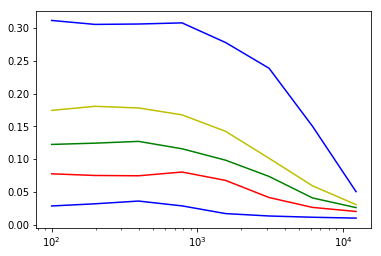

In [10]:
# plot and save
plt.xscale('log')
for i,c in enumerate(['b','r','g','y','b']):
    plt.plot(ms,err[:,i],c)
plt.show()

np.savetxt("csrandimg_"+img_name+".csv", np.vstack([ np.array(ms) ,np.array(err).T]).T , delimiter="\t")

## Compressive sensing on a natural image for varying number of parameters and number of measurements

In [11]:
# get a small image
img_name = "poster" # "F16_GT"
img_path = path + img_name + ".png"
img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)
img_np_small = np.array([crop_center(img_np[0],128,128)])
img_var = np_to_var(img_np_small).type(dtype)

numpoints = 8
ms = [ int(100*np.exp(5.5/numpoints*i)) for i in range(numpoints) ] #[100,200,,17000]
ks = [10,20,30,50,150,250]

err2 = np.zeros((len(ms), len(ks)))

numit = 10

for q in range(numit):
    for j,m in enumerate(ms):
        for ell,k in enumerate(ks):
        
            # generate fixed input
            num_channels = [k]*4
            ni = get_net_input(num_channels)
        
            #print("number useful variables / number observations", num_param(net)/m)
            print("number useful variables / number observations", (k**2*4 + k) /m)
            print("number observations / number of variables", m/n)
            print("m,n,nump",m,n,k**2*4 + k)

            A = 10*torch.empty(n,m).normal_(0, 1/np.sqrt(m)).type(dtype)
            
            def forwardm(img):
                X = img.view(-1 , np.prod(img.shape) )
                return torch.mm(X,A)
            
            # take measurement of original image
            measurement = forwardm(img_var).type(dtype)
            out_img_var = dd_recovery(measurement,img_var,num_channels,ni=ni,apply_f=forwardm,num_iter=6000)
        
            error = snr(out_img_var.data.cpu().numpy()[0] , img_var.data.cpu().numpy()[0])
            print("error: ", error, "\n")
            err2[j,ell] += error/numit

number useful variables / number observations 4.1
number observations / number of variables 0.006103515625
m,n,nump 100 16384 410
input provided
optimize with adam 0.005
610ration 05990    Train loss 0.000115  Actual loss 0.084647 Actual loss orig 0.084647    
error:  0.99586666 

number useful variables / number observations 16.2
number observations / number of variables 0.006103515625
m,n,nump 100 16384 1620
input provided
optimize with adam 0.005
2220ation 05990    Train loss 0.000000  Actual loss 0.044837 Actual loss orig 0.044837    
error:  0.52752805 

number useful variables / number observations 36.3
number observations / number of variables 0.006103515625
m,n,nump 100 16384 3630
input provided
optimize with adam 0.005
4830ation 05990    Train loss 0.000000  Actual loss 0.039256 Actual loss orig 0.039256    
error:  0.46186325 

number useful variables / number observations 100.5
number observations / number of variables 0.006103515625
m,n,nump 100 16384 10050
input provided
o

13050tion 05990    Train loss 0.011215  Actual loss 0.001326 Actual loss orig 0.001326   
error:  0.015611717 

number useful variables / number observations 57.64066496163683
number observations / number of variables 0.095458984375
m,n,nump 1564 16384 90150
input provided
optimize with adam 0.005
114150ion 05990    Train loss 0.000184  Actual loss 0.001153 Actual loss orig 0.001153   
error:  0.013616824 

number useful variables / number observations 160.00639386189258
number observations / number of variables 0.095458984375
m,n,nump 1564 16384 250250
input provided
optimize with adam 0.005
315250ion 05990    Train loss 0.098616  Actual loss 0.000681 Actual loss orig 0.000681   
error:  0.0076629524 

number useful variables / number observations 0.13183279742765272
number observations / number of variables 0.1898193359375
m,n,nump 3110 16384 410
input provided
optimize with adam 0.005
610ration 05990    Train loss 1.407205  Actual loss 0.004227 Actual loss orig 0.004227  
error:  0.

2220ation 05990    Train loss 0.020511  Actual loss 0.026276 Actual loss orig 0.026276    
error:  0.31004396 

number useful variables / number observations 18.333333333333332
number observations / number of variables 0.0120849609375
m,n,nump 198 16384 3630
input provided
optimize with adam 0.005
4830ation 05990    Train loss 0.012228  Actual loss 0.027494 Actual loss orig 0.027494    
error:  0.32346973 

number useful variables / number observations 50.75757575757576
number observations / number of variables 0.0120849609375
m,n,nump 198 16384 10050
input provided
optimize with adam 0.005
13050tion 05990    Train loss 0.023565  Actual loss 0.026395 Actual loss orig 0.026395    
error:  0.3108557 

number useful variables / number observations 455.3030303030303
number observations / number of variables 0.0120849609375
m,n,nump 198 16384 90150
input provided
optimize with adam 0.005
114150ion 05990    Train loss 0.000222  Actual loss 0.035376 Actual loss orig 0.035376  9 
error:  0.416

input provided
optimize with adam 0.005
315250ion 05990    Train loss 0.001398  Actual loss 0.000311 Actual loss orig 0.000311  
error:  0.0041958457 

number useful variables / number observations 0.0662786938247656
number observations / number of variables 0.3775634765625
m,n,nump 6186 16384 410
input provided
optimize with adam 0.005
610ration 05990    Train loss 0.742267  Actual loss 0.003644 Actual loss orig 0.003644  
error:  0.043266933 

number useful variables / number observations 0.2618816682832202
number observations / number of variables 0.3775634765625
m,n,nump 6186 16384 1620
input provided
optimize with adam 0.005
2220ation 05990    Train loss 0.102289  Actual loss 0.000681 Actual loss orig 0.000681  
error:  0.007832683 

number useful variables / number observations 0.5868089233753637
number observations / number of variables 0.3775634765625
m,n,nump 6186 16384 3630
input provided
optimize with adam 0.005
4830ation 05990    Train loss 0.050783  Actual loss 0.000431 Ac

13050tion 05990    Train loss 0.000817  Actual loss 0.007718 Actual loss orig 0.007718   
error:  0.09087409 

number useful variables / number observations 228.22784810126583
number observations / number of variables 0.02410888671875
m,n,nump 395 16384 90150
input provided
optimize with adam 0.005
114150ion 05990    Train loss 0.000001  Actual loss 0.007639 Actual loss orig 0.007639   
error:  0.08987384 

number useful variables / number observations 633.5443037974684
number observations / number of variables 0.02410888671875
m,n,nump 395 16384 250250
input provided
optimize with adam 0.005
315250ion 05990    Train loss 0.015723  Actual loss 0.008214 Actual loss orig 0.008214   
error:  0.09695375 

number useful variables / number observations 0.5216284987277354
number observations / number of variables 0.0479736328125
m,n,nump 786 16384 410
input provided
optimize with adam 0.005
610ration 05990    Train loss 3.463509  Actual loss 0.015152 Actual loss orig 0.015152   
error:  0.178

input provided
optimize with adam 0.005
2220ation 05990    Train loss 0.047923  Actual loss 0.000464 Actual loss orig 0.000464  
error:  0.0051205507 

number useful variables / number observations 0.29504998780785174
number observations / number of variables 0.75091552734375
m,n,nump 12303 16384 3630
input provided
optimize with adam 0.005
4830ation 05990    Train loss 0.035070  Actual loss 0.000381 Actual loss orig 0.000381  
error:  0.003642674 

number useful variables / number observations 0.8168739331870275
number observations / number of variables 0.75091552734375
m,n,nump 12303 16384 10050
input provided
optimize with adam 0.005
13050tion 05990    Train loss 0.014958  Actual loss 0.000182 Actual loss orig 0.000182  
error:  0.0020029605 

number useful variables / number observations 7.327481102170203
number observations / number of variables 0.75091552734375
m,n,nump 12303 16384 90150
input provided
optimize with adam 0.005
114150ion 05990    Train loss 0.005029  Actual loss 0

input provided
optimize with adam 0.005
315250ion 05990    Train loss 0.021857  Actual loss 0.002031 Actual loss orig 0.002031   
error:  0.023765728 

number useful variables / number observations 0.26214833759590794
number observations / number of variables 0.095458984375
m,n,nump 1564 16384 410
input provided
optimize with adam 0.005
610ration 05990    Train loss 2.411205  Actual loss 0.006101 Actual loss orig 0.006101   
error:  0.07067881 

number useful variables / number observations 1.0358056265984654
number observations / number of variables 0.095458984375
m,n,nump 1564 16384 1620
input provided
optimize with adam 0.005
2220ation 05990    Train loss 0.133860  Actual loss 0.002497 Actual loss orig 0.002497   
error:  0.02981324 

number useful variables / number observations 2.3209718670076724
number observations / number of variables 0.095458984375
m,n,nump 1564 16384 3630
input provided
optimize with adam 0.005
4830ation 05990    Train loss 0.111984  Actual loss 0.001787 Actu

13050tion 05990    Train loss 0.003525  Actual loss 0.038540 Actual loss orig 0.038540    
error:  0.45383587 

number useful variables / number observations 901.5
number observations / number of variables 0.006103515625
m,n,nump 100 16384 90150
input provided
optimize with adam 0.005
114150ion 05990    Train loss 0.468053  Actual loss 0.037683 Actual loss orig 0.037683  6 
error:  0.4464506 

number useful variables / number observations 2502.5
number observations / number of variables 0.006103515625
m,n,nump 100 16384 250250
input provided
optimize with adam 0.005
315250ion 05990    Train loss 0.000000  Actual loss 0.063084 Actual loss orig 0.063084    
error:  0.74220514 

number useful variables / number observations 2.0707070707070705
number observations / number of variables 0.0120849609375
m,n,nump 198 16384 410
input provided
optimize with adam 0.005
610ration 05990    Train loss 0.092043  Actual loss 0.058242 Actual loss orig 0.058242    
error:  0.68552244 

number useful var

input provided
optimize with adam 0.005
2220ation 05990    Train loss 0.176003  Actual loss 0.001125 Actual loss orig 0.001125  
error:  0.012847114 

number useful variables / number observations 1.167202572347267
number observations / number of variables 0.1898193359375
m,n,nump 3110 16384 3630
input provided
optimize with adam 0.005
4830ation 05990    Train loss 0.068528  Actual loss 0.000689 Actual loss orig 0.000689  
error:  0.0077744583 

number useful variables / number observations 3.2315112540192925
number observations / number of variables 0.1898193359375
m,n,nump 3110 16384 10050
input provided
optimize with adam 0.005
13050tion 05990    Train loss 0.018809  Actual loss 0.000523 Actual loss orig 0.000523  
error:  0.006104745 

number useful variables / number observations 28.987138263665596
number observations / number of variables 0.1898193359375
m,n,nump 3110 16384 90150
input provided
optimize with adam 0.005
114150ion 05990    Train loss 0.001343  Actual loss 0.000466 

input provided
optimize with adam 0.005
315250ion 05990    Train loss 0.000000  Actual loss 0.022071 Actual loss orig 0.022071    
error:  0.2596673 

number useful variables / number observations 1.0379746835443038
number observations / number of variables 0.02410888671875
m,n,nump 395 16384 410
input provided
optimize with adam 0.005
610ration 05990    Train loss 2.242336  Actual loss 0.055568 Actual loss orig 0.055568   
error:  0.65380096 

number useful variables / number observations 4.10126582278481
number observations / number of variables 0.02410888671875
m,n,nump 395 16384 1620
input provided
optimize with adam 0.005
2220ation 05990    Train loss 0.004935  Actual loss 0.014974 Actual loss orig 0.014974   
error:  0.17623265 

number useful variables / number observations 9.189873417721518
number observations / number of variables 0.02410888671875
m,n,nump 395 16384 3630
input provided
optimize with adam 0.005
4830ation 05990    Train loss 0.000004  Actual loss 0.011794 Actual

4830ation 05990    Train loss 0.061013  Actual loss 0.000448 Actual loss orig 0.000448  
error:  0.004632018 

number useful variables / number observations 1.6246362754607178
number observations / number of variables 0.3775634765625
m,n,nump 6186 16384 10050
input provided
optimize with adam 0.005
13050tion 05990    Train loss 0.024501  Actual loss 0.000300 Actual loss orig 0.000300  
error:  0.0033506656 

number useful variables / number observations 14.573229873908826
number observations / number of variables 0.3775634765625
m,n,nump 6186 16384 90150
input provided
optimize with adam 0.005
114150ion 05990    Train loss 0.006823  Actual loss 0.000139 Actual loss orig 0.000139  
error:  0.0015225598 

number useful variables / number observations 40.45425153572583
number observations / number of variables 0.3775634765625
m,n,nump 6186 16384 250250
input provided
optimize with adam 0.005
315250ion 05990    Train loss 0.025419  Actual loss 0.000209 Actual loss orig 0.000209  
error:  0

610ration 05990    Train loss 4.230757  Actual loss 0.019576 Actual loss orig 0.019576   
error:  0.23331082 

number useful variables / number observations 2.0610687022900764
number observations / number of variables 0.0479736328125
m,n,nump 786 16384 1620
input provided
optimize with adam 0.005
2220ation 05990    Train loss 0.038919  Actual loss 0.007706 Actual loss orig 0.007706   
error:  0.09102468 

number useful variables / number observations 4.6183206106870225
number observations / number of variables 0.0479736328125
m,n,nump 786 16384 3630
input provided
optimize with adam 0.005
4830ation 05990    Train loss 0.003277  Actual loss 0.004015 Actual loss orig 0.004015   
error:  0.047211885 

number useful variables / number observations 12.786259541984732
number observations / number of variables 0.0479736328125
m,n,nump 786 16384 10050
input provided
optimize with adam 0.005
13050tion 05990    Train loss 0.270448  Actual loss 0.004737 Actual loss orig 0.004737   
error:  0.0546

input provided
optimize with adam 0.005
114150ion 05990    Train loss 0.007418  Actual loss 0.000098 Actual loss orig 0.000098  
error:  0.0010148546 

number useful variables / number observations 20.340567341298872
number observations / number of variables 0.75091552734375
m,n,nump 12303 16384 250250
input provided
optimize with adam 0.005
315250ion 05990    Train loss 0.002131  Actual loss 0.000045 Actual loss orig 0.000045  
error:  0.000921424 

number useful variables / number observations 4.1
number observations / number of variables 0.006103515625
m,n,nump 100 16384 410
input provided
optimize with adam 0.005
610ration 05990    Train loss 0.572640  Actual loss 0.055364 Actual loss orig 0.055364    
error:  0.6470693 

number useful variables / number observations 16.2
number observations / number of variables 0.006103515625
m,n,nump 100 16384 1620
input provided
optimize with adam 0.005
2220ation 05990    Train loss 0.000008  Actual loss 0.043690 Actual loss orig 0.043690    
e

input provided
optimize with adam 0.005
4830ation 05990    Train loss 0.022630  Actual loss 0.001990 Actual loss orig 0.001990   
error:  0.02338741 

number useful variables / number observations 6.4258312020460355
number observations / number of variables 0.095458984375
m,n,nump 1564 16384 10050
input provided
optimize with adam 0.005
13050tion 05990    Train loss 0.001599  Actual loss 0.001287 Actual loss orig 0.001287   
error:  0.015101366 

number useful variables / number observations 57.64066496163683
number observations / number of variables 0.095458984375
m,n,nump 1564 16384 90150
input provided
optimize with adam 0.005
114150ion 05990    Train loss 0.000018  Actual loss 0.000945 Actual loss orig 0.000945   
error:  0.011118898 

number useful variables / number observations 160.00639386189258
number observations / number of variables 0.095458984375
m,n,nump 1564 16384 250250
input provided
optimize with adam 0.005
315250ion 05990    Train loss 0.017465  Actual loss 0.000818 

610ration 05990    Train loss 0.000102  Actual loss 0.060542 Actual loss orig 0.060542    
error:  0.71233785 

number useful variables / number observations 8.181818181818182
number observations / number of variables 0.0120849609375
m,n,nump 198 16384 1620
input provided
optimize with adam 0.005
2220ation 05990    Train loss 0.000000  Actual loss 0.024993 Actual loss orig 0.024993   
error:  0.29404902 

number useful variables / number observations 18.333333333333332
number observations / number of variables 0.0120849609375
m,n,nump 198 16384 3630
input provided
optimize with adam 0.005
4830ation 05990    Train loss 0.000000  Actual loss 0.020076 Actual loss orig 0.020076    
error:  0.23620261 

number useful variables / number observations 50.75757575757576
number observations / number of variables 0.0120849609375
m,n,nump 198 16384 10050
input provided
optimize with adam 0.005
13050tion 05990    Train loss 0.000017  Actual loss 0.018491 Actual loss orig 0.018491    
error:  0.2175

input provided
optimize with adam 0.005
114150ion 05990    Train loss 0.035397  Actual loss 0.000476 Actual loss orig 0.000476  
error:  0.005127462 

number useful variables / number observations 80.46623794212219
number observations / number of variables 0.1898193359375
m,n,nump 3110 16384 250250
input provided
optimize with adam 0.005
315250ion 05990    Train loss 0.004449  Actual loss 0.000328 Actual loss orig 0.000328  
error:  0.0038400232 

number useful variables / number observations 0.0662786938247656
number observations / number of variables 0.3775634765625
m,n,nump 6186 16384 410
input provided
optimize with adam 0.005
610ration 05990    Train loss 0.575950  Actual loss 0.002858 Actual loss orig 0.002858  
error:  0.03476223 

number useful variables / number observations 0.2618816682832202
number observations / number of variables 0.3775634765625
m,n,nump 6186 16384 1620
input provided
optimize with adam 0.005
2220ation 05990    Train loss 0.104655  Actual loss 0.000709 Ac

4830ation 05990    Train loss 0.000000  Actual loss 0.007663 Actual loss orig 0.007663   
error:  0.09015827 

number useful variables / number observations 25.443037974683545
number observations / number of variables 0.02410888671875
m,n,nump 395 16384 10050
input provided
optimize with adam 0.005
13050tion 05990    Train loss 0.000002  Actual loss 0.008246 Actual loss orig 0.008246   
error:  0.0970191 

number useful variables / number observations 228.22784810126583
number observations / number of variables 0.02410888671875
m,n,nump 395 16384 90150
input provided
optimize with adam 0.005
114150ion 05990    Train loss 0.000008  Actual loss 0.007714 Actual loss orig 0.007714   
error:  0.09076037 

number useful variables / number observations 633.5443037974684
number observations / number of variables 0.02410888671875
m,n,nump 395 16384 250250
input provided
optimize with adam 0.005
315250ion 05990    Train loss 0.000000  Actual loss 0.005559 Actual loss orig 0.005559   
error:  0.0

input provided
optimize with adam 0.005
610ration 05990    Train loss 0.304709  Actual loss 0.002607 Actual loss orig 0.002607  
error:  0.029298972 

number useful variables / number observations 0.13167520117044623
number observations / number of variables 0.75091552734375
m,n,nump 12303 16384 1620
input provided
optimize with adam 0.005
2220ation 05990    Train loss 0.049664  Actual loss 0.000500 Actual loss orig 0.000500  
error:  0.0055079754 

number useful variables / number observations 0.29504998780785174
number observations / number of variables 0.75091552734375
m,n,nump 12303 16384 3630
input provided
optimize with adam 0.005
4830ation 05990    Train loss 0.025555  Actual loss 0.000285 Actual loss orig 0.000285  
error:  0.003133672 

number useful variables / number observations 0.8168739331870275
number observations / number of variables 0.75091552734375
m,n,nump 12303 16384 10050
input provided
optimize with adam 0.005
13050tion 05990    Train loss 0.010444  Actual loss 0

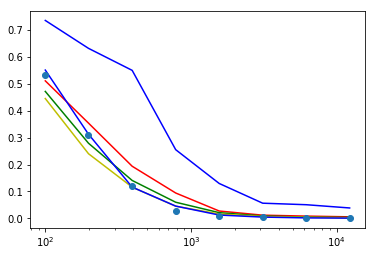

In [12]:
# plot and save
plt.xscale('log')
for i,c in enumerate(['b','r','g','y','b','o']):
    plt.plot(ms,err2[:,i],c)
plt.show()

np.savetxt("csf16img_"+img_name+".csv", np.vstack([ np.array(ms) ,np.array(err2).T]).T , delimiter="\t")